In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

%matplotlib inline

# Likelihood and Maximum Likelihood Estimation

The normal density function is given by,
$$
f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}\left(
    \frac{x-\mu}{\sigma} \right)^2}
$$

The likelihood of of an observed x-value, say $x_1$ is simply $\mathscr{l} = f(x_1)$.  If there are multple x-values, $x_1, x_2, x_3, \cdots , x_N$, the the likelihood is given py the product of the individual likelihoods,
$$
\mathscr{l} = \prod_{i=1}^N f(x_i)
$$

We want to find $\mu$ and $\sigma$ given a bunch of x-values and assuming a normal distribution.  We do this my choosing $\mu$ and $\sigma$ as to maximize the likelihood.  In practice, one actually maximizes the log of the likelihood as this doesn't affect the estiamted values of our unknown parameters, but does simplify the calculation, both analytically and numerically.

See the Wikipedia article on maximum likelihood and the derivation for the normal distribution:  https://en.wikipedia.org/wiki/Maximum_likelihood_estimation#Continuous_distribution,_continuous_parameter_space


We find the maximum by setting the derivatives equal to zero:

$$\frac{d\ln(\mathscr{l})}{d\mu} = 0$$
and
$$
\frac{d\ln(\mathscr{l})}{d\sigma} = 0
$$

If we solve these we get,
$$
\mu^* = \frac{1}{N}\sum^N_{i = 1} x_i
$$
and
$$\sigma^* = \sqrt{
\frac{1}{N}\sum^N_{i=1} (x_i - \mu^*)^2}
$$

The results for the normal distribution turn out to be the sample mean and standard deviation

0.03315904626424956
0.08065690817304778
0.0026745061496414196


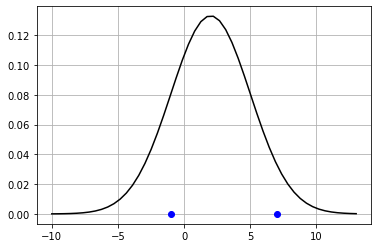

In [62]:
mu = 2
sigma = 3

x = np.linspace(-10, 13)
y = norm.pdf(x, loc = mu, scale = sigma)

plt.plot(x, y, 'k')
plt.grid(True)

x1 = 7
x2 = -1

plt.plot(x1, 0, 'bo')
plt.plot(x2, 0, 'bo')
#plt.savefig('normal.png')

l1 = norm.pdf(x1, loc = mu, scale = sigma)
l2 = norm.pdf(x2, loc = mu, scale = sigma)

print(l1)
print(l2)

print(l1 * l2)

In [63]:
def log_likelihood(p, x):
    mu = p[0]
    sigma = p[1]
    
    l = np.sum( np.log( norm.pdf(x, loc = mu, scale = sigma) ) )
    
    return -l 

def constraint(p):
    sigma = p[1]
    
    return sigma

In [64]:
np.random.seed(123)
N = 100

x = np.random.normal(loc = mu, scale = sigma, size = (N,))
#plt.plot(x, 'k')
#plt.grid(True)
#plt.savefig('random.png')

print(np.mean(x))
print(np.std(x))

2.0813272204710795
3.384721411433883


In [65]:
cons = {'type':'ineq', 'fun': constraint}

p0 = [0, 1]

minimize(log_likelihood, p0, args=(x,), constraints=cons )

     fun: 263.8210135314002
     jac: array([2.59399414e-04, 3.81469727e-06])
 message: 'Optimization terminated successfully.'
    nfev: 58
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([2.08135664, 3.38472116])

# Ornstein-Uhlenbeck Process

$$ dX_t = \mu(\theta - X_t) dt + \sigma dW_t$$

$$X_i - x_{i-1} = \mu(\theta - X_i) (t_i - t_{i-1}) + \sigma\sqrt{t_i - t_{i-1}}W_t$$

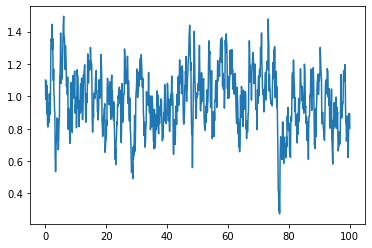

In [66]:
np.random.seed(123)

theta = 1
mu = 1.5
sigma = 0.3

t = np.linspace(0, 100, 1001)
dt = t[1] - t[0]

X = np.zeros( t.shape )
X[0] = 1.1

for i in range( t.size-1 ):
    X[i+1] = X[i] + mu * (theta - X[i]) * dt + sigma * np.sqrt(dt) * np.random.normal()
    
plt.plot(t, X)

$$
f^{OU}(x_i|x_{i-1}; \theta,\mu,\sigma) = \frac{1}{\sqrt{2\pi\tilde{\sigma}^2}}\mbox{Exp}\left(
-\frac{(x_i - x_{i-1}e^{-\mu\Delta t} - \theta(1 - e^{-\mu\Delta t}))^2}{2\tilde{\sigma}^2}
\right)
$$

with $\tilde{\sigma}$ defined as,

$$
\tilde{\sigma}^2 = \sigma^2 \frac{1-e^{-2\mu \Delta t}}{2\mu}.
$$

In [77]:
def OU(x1, x2, dt, theta, mu, sigma):
    sigma0 = sigma**2 * (1 - np.exp(-2*mu*dt)) / (2 * mu)
    sigma0 = np.sqrt( sigma0 )
    
    prefactor = 1 / np.sqrt(2 * np.pi * sigma0**2)
    
    f =  prefactor * np.exp( -(x2 - x1 * np.exp(-mu*dt) - \
                    theta * (1-np.exp(-mu*dt)) )**2 / (2 * sigma0**2) )
    
    return f

def log_likelihood_OU(p, X, dt):
    
    theta = p[0]
    mu = p[1]
    sigma = p[2]
    
    N = X.size
    
    f = np.zeros( (N-1, ) )
    
    for i in range( 1, N ):
        x2 = X[i]
        x1 = X[i-1]
        
        f[i-1] = OU(x1, x2, dt, theta, mu, sigma)
    
    ind = np.where(f == 0)
    ind = ind[0]
    if ind.size > 0:
        f[ind] = 10**-8
        
    f = np.log(f)
    f = np.sum(f)
        
    return -f

def constraint1( p ):
    return p[1]

def constraint2( p ):
    return p[2]

In [78]:
cons = ( {'type':'ineq', 'fun': constraint1},
         {'type':'ineq', 'fun': constraint2} )

p0 = [1, 1, 1]

minimize(log_likelihood_OU, p0, args = (X, dt), constraints=cons)

C:\Users\moone\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


     fun: -935.5940335771147
     jac: array([-0.00041199,  0.00058746,  0.01727295])
 message: 'Optimization terminated successfully.'
    nfev: 166
     nit: 28
    njev: 28
  status: 0
 success: True
       x: array([0.97490342, 1.56178286, 0.32394579])

Define

$$
X_x = \sum_{i=1}^N x_{i-1}
$$

$$
X_y = \sum_{i=1}^N x_i
$$

$$
X_{xx} = \sum_{i=1}^N (x_{i-1})^2
$$

$$
X_{xy} = \sum_{i=1}^N x_{i-1} x_i
$$

$$
X_{yy} = \sum_{i=1}^N (x_i)^2
$$

The optimal parameters are given by,


$$
\theta^* = \frac{X_y X_{xx} - X_x X_{xy}}
{N(X_{xx} - X_{xy} - (X_x^2 - X_xX_y)}
$$

$$
\mu^* = \frac{1}{\Delta t} \ln\left(
\frac{X_{xy} - \theta^*X_x - \theta^*X_y + N(\theta^*)^2}
{X_{xx} - 2\theta^*X_x + N(\theta^*)^2}\right)
$$


\begin{multline}
(\sigma^*)^2 = \frac{2\mu^*}{N(1-e^{-2\mu^*\Delta t})} (X_{yy} - 2e^{-\mu^*\Delta t} X_{xy} + e^{-2\mu^*\Delta t}X_{xx} \\
- 2\theta^* (1-e^{-\mu^*\Delta t})(X_y - e^{-\mu^*\Delta t})X_x + N(\theta^*)^2(1-e^{-\mu^*\Delta t})^2)
\end{multline}

In [81]:
N = X.size
Xx  = np.sum(X[0:-1])
Xy  = np.sum(X[1:])
Xxx = np.sum(X[0:-1]**2)
Xxy = np.sum(X[0:-1] * X[1:])
Xyy = np.sum(X[1:]**2)

theta0 = (Xy * Xxx - Xx * Xxy) /  \
    (N * (Xxx - Xxy) - (Xx**2 - Xx * Xy) )

mu0 = (Xxy - theta0 * Xx - theta0 * Xy + N * theta0**2) / \
    (Xxx - 2 * theta0 * Xx + N * theta0**2)
mu0 = -1 / dt * np.log(mu0)

prefactor = 2 * mu0 / (N*(1-np.exp(-2*mu0*dt)))
term = Xyy - 2*np.exp(-mu0*dt) * Xxy + np.exp(-2*mu0*dt) * Xxx - 2*theta0*(1-np.exp(-mu0*dt)) * (Xy - Xx * np.exp(-mu0*dt)) + N * theta0**2* ( 1-np.exp(-mu0 * dt))**2

sigma02 = prefactor * term

print(theta0)
print(mu0)
print(np.sqrt(sigma02))

0.9738715922866101
1.5152361730170372
0.3234146023399549
